<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/24th%20April%20converting%20to%20time%20series%20and%20predicting%20with%20MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import requests
from scipy import stats

import lightgbm as lgb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [125]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

In [126]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [127]:
train.shape

(14687, 14)

In [128]:
train = pd.concat([train, target], axis=1)

In [129]:
train

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,target_r,target_g,target_b
0,1.00,1.00,0.0,0.00,1.00,0.50,1.00,0.0,1.0,0.0,0.0,0.25,0.00,0.25,1.00,1.00,0.75
1,1.00,1.00,0.0,0.00,0.50,0.50,0.50,0.0,1.0,0.0,0.0,0.00,0.00,0.00,0.75,0.25,0.50
2,0.50,0.50,0.0,0.00,0.25,0.75,0.00,0.0,1.0,0.0,0.0,0.00,0.25,0.25,0.75,0.00,0.00
3,0.75,0.75,0.0,0.00,0.50,1.00,0.00,0.0,0.0,0.0,1.0,0.00,0.50,0.00,0.25,0.00,0.25
4,1.00,1.00,0.0,0.00,1.00,1.00,0.25,0.0,0.0,0.0,1.0,0.25,0.25,0.50,0.75,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14682,0.00,0.00,1.0,0.75,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14683,0.25,0.25,1.0,0.75,0.25,0.75,0.25,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50
14684,0.25,0.25,1.0,1.00,0.25,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.25,0.00
14685,0.00,0.00,1.0,0.75,0.00,0.75,0.00,1.0,0.0,0.0,0.0,0.00,0.75,0.75,0.00,0.50,0.50


In [130]:
# train = train.drop(['Moons', 'id'], axis=1)

In [131]:
train.shape[0] - (4687)

10000

In [132]:
validation_data = train[10000: ]
train_data = train[:10000]
train_data.shape

(10000, 17)

In [133]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

# TRAINING

In [134]:
def scorer(y_test, y_pred):
    score = (stats.spearmanr(y_test, y_pred))[0]
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
    return score

In [135]:
# train[:10][['Feature_1', 'target_r']]

In [136]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-3], sequences[end_ix-1, -3:]
        # print(seq_x.shape)
        # print(seq_y.shape)
        # print(seq_x, seq_y)
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



In [137]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)

In [138]:
train_data_arr.shape, validation_data_arr.shape

((10000, 17), (4687, 17))

In [139]:
%matplotlib inline
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

TIME STEPS : -------->  16
Epoch 00016: early stopping


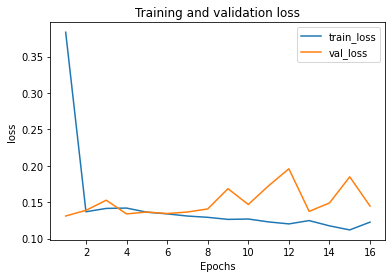

[16, 0.1394958160539915, 0.12484419090548798, 0.04429748153950751]
 
 
TIME STEPS : -------->  17
Epoch 00022: early stopping


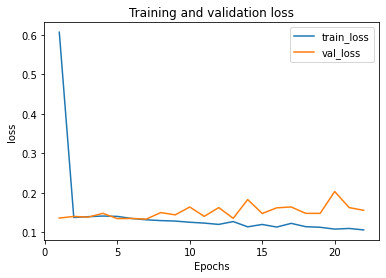

[17, 0.03216309286009576, 0.11840655525394862, 0.07602042386045603]
 
 
TIME STEPS : -------->  18
Epoch 00022: early stopping


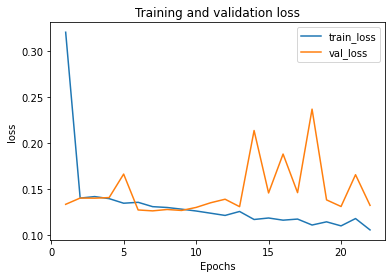

[18, 0.06287773364619005, 0.11765049255191525, 0.07608423557168845]
 
 
TIME STEPS : -------->  19
Epoch 00024: early stopping


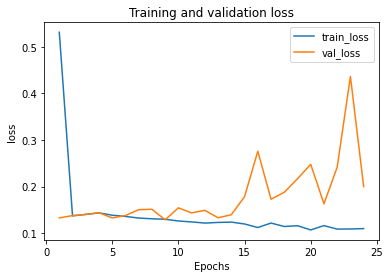

[19, 0.03370712731145443, 0.08765300892959453, 0.08678707093287286]
 
 
TIME STEPS : -------->  20
Epoch 00021: early stopping


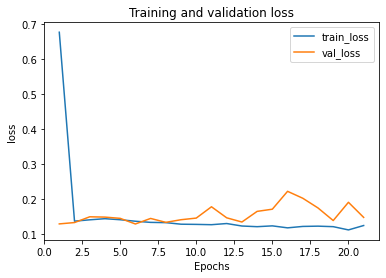

[20, 0.05344226811940906, 0.10547513494476164, 0.06772846311505044]
 
 
TIME STEPS : -------->  21
Epoch 00021: early stopping


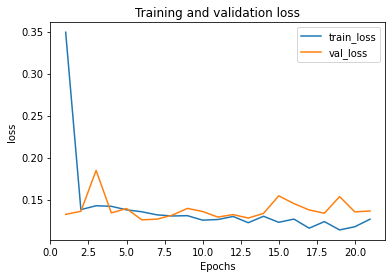

[21, 0.05112986113909814, 0.11264842138143531, 0.05782001825990745]
 
 
TIME STEPS : -------->  22
Epoch 00028: early stopping


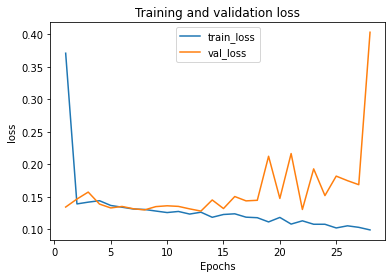

[22, 0.0893085079715065, 0.16036870381835602, 0.11380648771265756]
 
 
TIME STEPS : -------->  23
Epoch 00032: early stopping


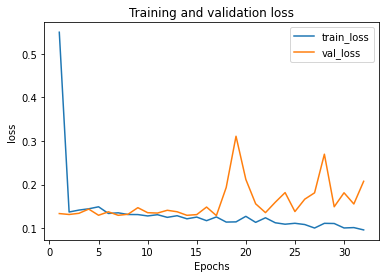

[23, 0.09220085288417719, 0.1626262163981759, 0.11023758446452356]
 
 
TIME STEPS : -------->  24
Epoch 00016: early stopping


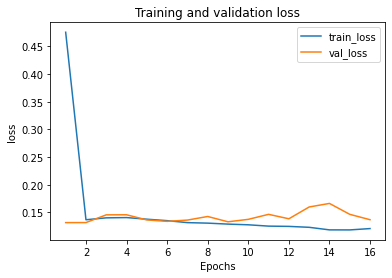

[24, 0.12688084067113106, 0.13948706516576648, 0.04615578742749515]
 
 
TIME STEPS : -------->  25
Epoch 00027: early stopping


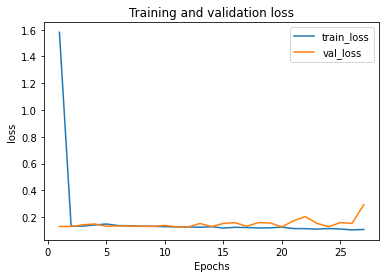

[25, 0.074956745489812, 0.15012513864828148, 0.1096771341145258]
 
 
TIME STEPS : -------->  26
Epoch 00021: early stopping


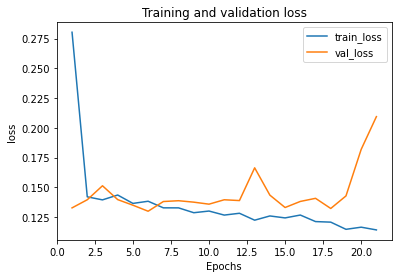

[26, 0.0850077054900795, 0.15640605873990254, 0.09021778032586146]
 
 
TIME STEPS : -------->  27
Epoch 00027: early stopping


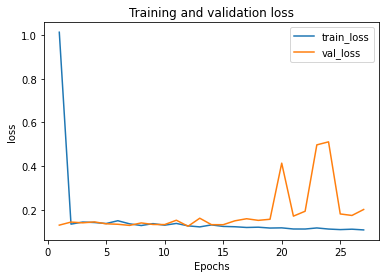

[27, 0.06233845956957028, 0.12955421651971888, 0.09153738546351534]
 
 


In [140]:
np.random.seed(60)
df = []
for i in range(16, 28):
    n_steps = i
    print( "TIME STEPS : --------> " , i)
    X_train, y_train = split_sequences(train_data_arr, n_steps)
    X_val, y_val = split_sequences(validation_data_arr, n_steps)

    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    X_val = X_val.reshape((X_val.shape[0], n_input))

    from keras.models import Sequential
    from keras.layers import Dense


    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=n_input))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(3))
    model.compile(optimizer='rmsprop', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
    mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    batch_size = 512
    epochs = 250

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=None, validation_data=(X_val, y_val), 
                        callbacks=[early_stopping, mcp_save], shuffle=False)

    
    plot_metric(history, 'loss')
    plt.show()

    model.load_weights('model.hdf5')
    preds= model.predict(X_val, batch_size=batch_size)
    cols = ['target_r', 'target_g', 'target_b']
    preds = pd.DataFrame(preds, columns=cols)

    scores = []
    scores.append(n_steps)
    scores.append(scorer(y_val[:, 0], preds.target_r))
    scores.append(scorer(y_val[:, 1], preds.target_g))
    scores.append(scorer(y_val[:, 2], preds.target_b))
    df.append(pd.DataFrame(scores))
    print(scores)
    print(" ")
    print(" ")


In [141]:
# df

In [142]:
df = pd.concat(df, axis=1)
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)

In [143]:
df.T

,1,2,3
0,,,
16.0,0.139496,0.124844,0.044297
17.0,0.032163,0.118407,0.076020
18.0,0.062878,0.117650,0.076084
19.0,0.033707,0.087653,0.086787
20.0,0.053442,0.105475,0.067728
21.0,0.051130,0.112648,0.057820
22.0,0.089309,0.160369,0.113806
23.0,0.092201,0.162626,0.110238
24.0,0.126881,0.139487,0.046156


In [ ]:
# df.T.max()

# NEW

In [144]:
train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [145]:
train = pd.concat([train, target], axis=1)
# train = train.drop(['id', 'Moons'], axis=1)

In [146]:
train.shape

(14687, 17)

In [147]:
features = [f for f in train_data.columns if 'Feature' in f]
len(features)

14

In [148]:
validation_data = train[10000: ]
train_data = train[:10000]

In [152]:
validation_data.shape[0] - 23

4664

In [153]:
test_merge = validation_data[4665:]
test_merge.shape

(22, 17)

In [154]:
test.shape

(12910, 14)

In [155]:
cols = ['target_r', 'target_g', 'target_b']
test_merge.drop(columns=cols, inplace=True)

In [156]:
validation_data = validation_data[:4665]
validation_data.shape

(4665, 17)

In [157]:
train_data_arr = np.array(train_data)
validation_data_arr = np.array(validation_data)
validation_data_arr.shape

(4665, 17)

(9978, 23, 14)
(4643, 23, 14)
Epoch 00023: early stopping


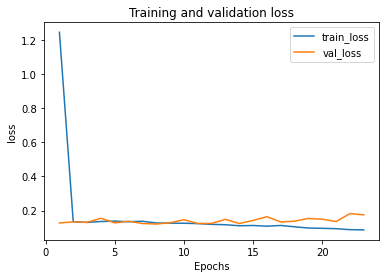

0.1374948809451755
0.15799596171153474
0.11042036685312426


In [159]:
np.random.seed(60)
n_steps = 23
X_train, y_train = split_sequences(train_data_arr, n_steps)
print(X_train.shape)
X_val, y_val = split_sequences(validation_data_arr, n_steps)
print(X_val.shape)
n_input = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], n_input))
X_val = X_val.reshape((X_val.shape[0], n_input))

from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=n_input))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3))
model.compile(optimizer='rmsprop', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mcp_save = ModelCheckpoint('./model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

batch_size = 512
epochs = 250


history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=0, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, mcp_save], shuffle=True)


plot_metric(history, 'loss')

model.load_weights('model.hdf5')
preds= model.predict(X_val, batch_size=batch_size)
cols = ['target_r', 'target_g', 'target_b']
preds = pd.DataFrame(preds, columns=cols)

print(scorer(y_val[:, 0], preds.target_r))
print(scorer(y_val[:, 1], preds.target_g))
print(scorer(y_val[:, 2], preds.target_b))

In [160]:
X_val.shape

(4643, 322)

In [161]:
test_data_with_lag = pd.concat([test_merge, test])
test_data_with_lag.shape

(12932, 14)

In [162]:
test.shape[0]

12910

In [163]:
def split_sequences_for_prediction(sequences, n_steps):
    X= list()   
    for i in range(len(sequences)):
# find the end of this pattern
        end_ix = i + n_steps
# check if we are beyond the dataset
        if end_ix > len(sequences):
            break
# gather input and output parts of the pattern
        seq_x =sequences[i:end_ix]
        # print(seq_x)
        X.append(seq_x)
    return np.array(X)

In [165]:
preds_data = split_sequences_for_prediction(np.array(test_data_with_lag[features]), 23)

In [166]:
preds_data.shape

(12910, 23, 14)

In [167]:
n_input

322

In [168]:
preds_data = preds_data.reshape((preds_data.shape[0], n_input))
preds_data.shape

(12910, 322)

In [169]:
prediction = pd.DataFrame(model.predict(preds_data, batch_size=batch_size))

In [170]:
prediction.columns = cols

In [171]:
prediction

,target_r,target_g,target_b
0,0.506338,0.580899,0.553027
1,0.516241,0.552630,0.541658
2,0.481900,0.558055,0.511667
3,0.516952,0.547783,0.546006
4,0.487643,0.511371,0.510762
...,...,...,...
12905,0.452325,0.473099,0.506723
12906,0.523806,0.564878,0.584224
12907,0.580788,0.613855,0.617903
12908,0.590540,0.597934,0.627259


In [172]:
test.shape, prediction.shape

((12910, 14), (12910, 3))

# Predictions

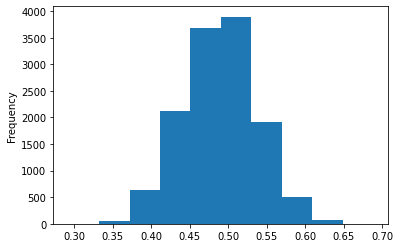

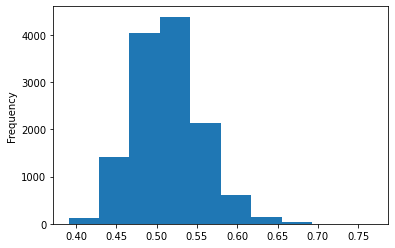

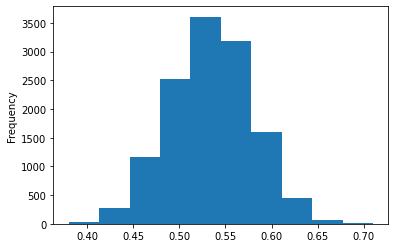

In [175]:
prediction['target_r'].plot(kind='hist')
plt.show()
prediction['target_g'].plot(kind='hist')
plt.show()
prediction['target_b'].plot(kind='hist')
plt.show()

In [176]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)
